In [1]:
%matplotlib inline

In [111]:
import os
import pickle
import sys
from collections import defaultdict
from random import random

import Orange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from tqdm.notebook import tqdm


sys.path.append('../../pygkernels')
from pygkernels.measure import kernels

In [21]:
def shuffle(dct):
    return sorted(dct, key=lambda x: random())

shuffle([1, 2, 3])

[3, 2, 1]

In [108]:
def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for _, classifier_accuracy in results.items():
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

# Compare init strategies (one, all, kmeans++)

In [22]:
kernels_order = [x.name for x in kernels]
list(enumerate(kernels_order))

[(0, 'Katz'),
 (1, 'logKatz'),
 (2, 'For'),
 (3, 'logFor'),
 (4, 'Comm'),
 (5, 'logComm'),
 (6, 'Heat'),
 (7, 'logHeat'),
 (8, 'NHeat'),
 (9, 'logNHeat'),
 (10, 'SCT'),
 (11, 'SCCT'),
 (12, 'RSP'),
 (13, 'FE'),
 (14, 'PPR'),
 (15, 'logPPR'),
 (16, 'ModifPPR'),
 (17, 'logModifPPR'),
 (18, 'HeatPR'),
 (19, 'logHeatPR'),
 (20, 'DF'),
 (21, 'logDF'),
 (22, 'Abs'),
 (23, 'logAbs'),
 (24, 'SP-CT')]

In [141]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'

dataset = []
for fn in tqdm(os.listdir(root)):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
        
        
    if not np.max([[np.max(['new_modularity2' in z for z in y] + [False]) for y in x.values()] for x in data['results'].values()]):
        print(f'no new_modularity2 in {fn}')
        continue
    
    kernel_results = defaultdict(lambda: defaultdict(lambda: -1))
    for kernel_name in kernels_order:
        for param in np.linspace(0, 1, 16):
            inits = {
                'one': [init for init in data['results'][kernel_name][param] if init['init'] == 'one'],  # 6
                'all': [init for init in data['results'][kernel_name][param] if init['init'] == 'all'],  # 6
                'kmp': [init for init in data['results'][kernel_name][param] if init['init'] == 'k-means++']  # 6
            }
            inits['3one+3all'] = shuffle(inits['one'])[:3] + shuffle(inits['all'])[:3] # 3 + 3
            inits['3all+3kmp'] = shuffle(inits['all'])[:3] + shuffle(inits['kmp'])[:3] # 3 + 3
            inits['3one+3kmp'] = shuffle(inits['one'])[:3] + shuffle(inits['kmp'])[:3] # 3 + 3
            inits['2one+2all+2kmp'] = shuffle(inits['one'])[:2] + shuffle(inits['all'])[:2] + shuffle(inits['kmp'])[:2] # 2 + 2 + 2
            
            inits['6one+6all'] = inits['one'] + inits['all']
            inits['6all+6kmp'] = inits['all'] + inits['kmp']
            inits['6one+6kmp'] = inits['one'] + inits['kmp']
            inits['6one+6all+6kmp'] = inits['one'] + inits['all'] + inits['kmp']
            
            for init_name in inits.keys():
                if len(inits[init_name]) > 0:
                    init_ari = sorted([init for init in inits[init_name]], key=lambda x: -x['new_modularity2'])[0]['score_ari']
                    if kernel_results[kernel_name][init_name] < init_ari:
                        kernel_results[kernel_name][init_name] = init_ari
    dataset.append(kernel_results)

no new_modularity2 in 1174_58.43_4.98_0.97_599.19_238.00.pkl
no new_modularity2 in 1378_23.47_16.36_0.30_413.48_417.00.pkl
no new_modularity2 in 598_1.37_5.15_0.53_30.84_280.00.pkl
no new_modularity2 in 1064_69.05_1.04_0.35_651.72_408.00.pkl
no new_modularity2 in 829_22.42_31.68_0.22_208.11_258.00.pkl
no new_modularity2 in 111_72.49_4.55_0.78_84.93_43.00.pkl
no new_modularity2 in 620_4.03_1.44_0.34_287.48_101.00.pkl
no new_modularity2 in 338_100.00_1.28_0.77_171.65_53.00.pkl
no new_modularity2 in 1317_1.73_2.19_0.58_20.62_147.00.pkl
no new_modularity2 in 921_67.49_15.05_1.00_616.15_146.00.pkl



# For all measures

n_experiments: 55401


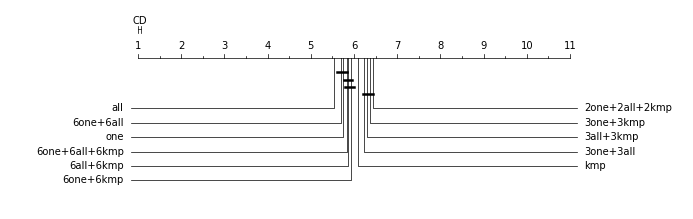

In [142]:
X = defaultdict(dict) 
for graph_idx, item in enumerate(dataset):
    for kernel_name, measure_results in item.items():
        for init_strategy_name, init_strategy_result in measure_results.items():
            X[f'{graph_idx}_{kernel_name}'][init_strategy_name] = init_strategy_result
            
avranks, names, n_experiments = calc_avranks(X)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

# For every measure

In [143]:
table = dict()
for kernel_name in kernels_order:
    X = defaultdict(dict) 
    for graph_idx, item in enumerate(dataset):
        for init_strategy_name, init_strategy_result in item[kernel_name].items():
            X[f'{graph_idx}_{kernel_name}'][init_strategy_name] = init_strategy_result

    avranks, names, n_experiments = calc_avranks(X)
#     print(f'{kernel_name}, n_experiments: {n_experiments}')
    cd = Orange.evaluation.compute_CD(avranks, n_experiments)
#     Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
#     plt.show()
    
    table[kernel_name] = {k: (np.max(avranks) - v) < cd for k, v in zip(names, avranks)}

In [145]:
df = pd.DataFrame(table).transpose()#[['one', 'all', 'kmp', 'one+all', 'one+kmp', 'all+kmp', 'one+all+kmp']]
df

,2one+2all+2kmp,3all+3kmp,3one+3all,3one+3kmp,6all+6kmp,6one+6all,6one+6all+6kmp,6one+6kmp,all,kmp,one
Katz,True,True,False,True,False,False,False,False,False,True,False
logKatz,False,False,False,True,False,False,False,False,False,True,False
For,True,True,False,False,False,False,False,False,False,False,False
logFor,False,False,False,True,False,False,False,True,False,True,False
Comm,False,False,True,False,False,False,False,False,True,False,False
logComm,True,True,True,True,True,True,False,True,True,True,True
Heat,False,False,False,False,False,False,False,False,True,False,False
logHeat,False,False,False,False,False,False,False,False,True,False,False
NHeat,True,True,True,False,False,False,False,False,True,False,False
logNHeat,True,False,False,True,False,False,False,False,False,False,False


In [148]:
sorted({k: np.sum(list(v.values())) / len(v) for k, v in df.to_dict().items()}.items(), key=lambda x: -x[1])

[('3one+3kmp', 0.64),
 ('2one+2all+2kmp', 0.6),
 ('kmp', 0.44),
 ('3all+3kmp', 0.4),
 ('3one+3all', 0.28),
 ('all', 0.28),
 ('one', 0.16),
 ('6all+6kmp', 0.08),
 ('6one+6all', 0.08),
 ('6one+6kmp', 0.08),
 ('6one+6all+6kmp', 0.04)]